In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor
from cities.utils.data_loader import db_connection

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

from cities.modeling.zoning_models.zoning_tracts_population import TractsModelPopulation
from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic


from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm

from cities.utils.data_loader import select_from_sql


root = find_repo_root()


smoke_test = "CI" in os.environ
n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

In [14]:

census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",
        "housing_units_original",
        "total_value",
        "total_population",
        "population_density",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        'limit',
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

print(subset['continuous'].keys())

dict_keys(['mean_limit_original', 'median_distance', 'total_value', 'median_value', 'housing_units', 'parcel_sqm', 'income', 'housing_units_original', 'segregation_original', 'total_population', 'university_overlap', 'population_density', 'white_original', 'downtown_overlap'])


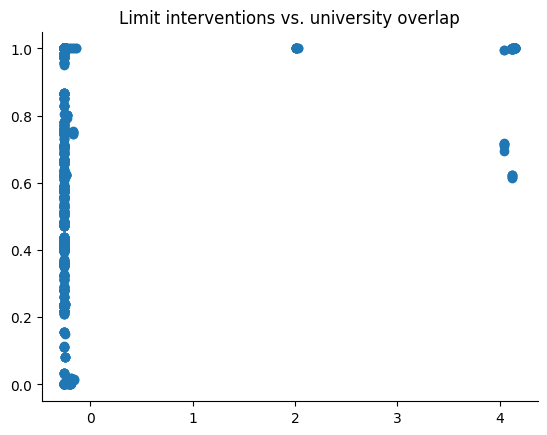

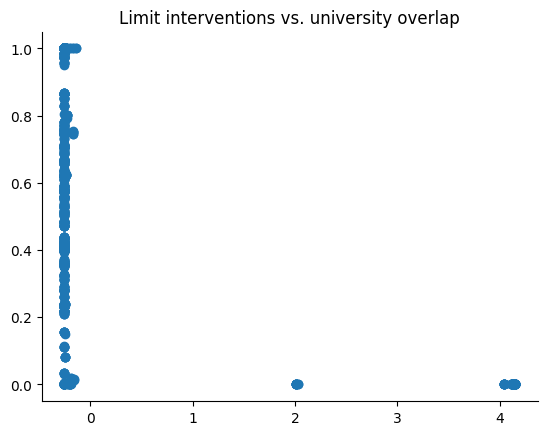

In [3]:


plt.scatter(subset['continuous']['university_overlap'], subset['continuous']['mean_limit_original'], label='observed')
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()

# set to zero whenever the university overlap is above 1
subset['continuous']['mean_limit_original'] = torch.where(subset['continuous']['university_overlap'] > 1, 
                                                          torch.zeros_like(subset['continuous']['mean_limit_original']), 
                                                          subset['continuous']['mean_limit_original'])


plt.scatter(subset['continuous']['university_overlap'], subset['continuous']['mean_limit_original'], label='observed')
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()


In [4]:

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


In [5]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


In [7]:
population_preds_path = "population_preds.dill"
sqm_preds_path = "sqm_preds.dill"
interaction_preds_path = "interactions_preds.dill"

with open(population_preds_path, "rb") as f:
    population_preds = dill.load(f)

with open(sqm_preds_path, "rb") as f:
    sqm_preds = dill.load(f)

with open(interaction_preds_path, "rb") as f:
    interactions_preds = dill.load(f)


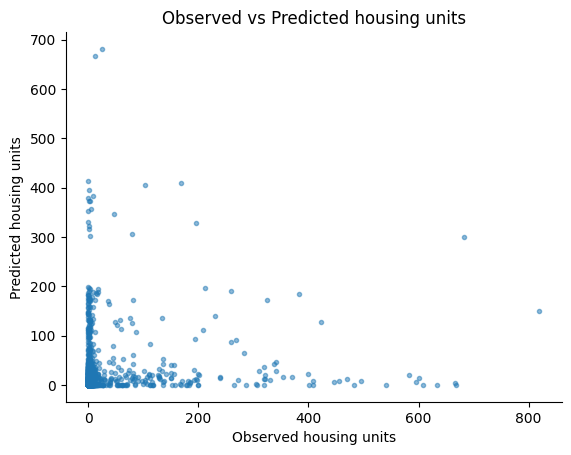

In [15]:

pop_preds_units = destandardize_housing_units(population_preds["housing_units"])
pop_preds_units_mean = pop_preds_units.mean(dim=0).clamp(min = 0).detach().numpy()
units_observed_original = subset['continuous']['housing_units_original'].detach().numpy()

plt.scatter(y = pop_preds_units_mean ,
             x = units_observed_original, s= 9, alpha = .5)
plt.xlabel("Observed housing units")
plt.ylabel("Predicted housing units")
plt.title("Observed vs Predicted housing units")
sns.despine()
plt.show()

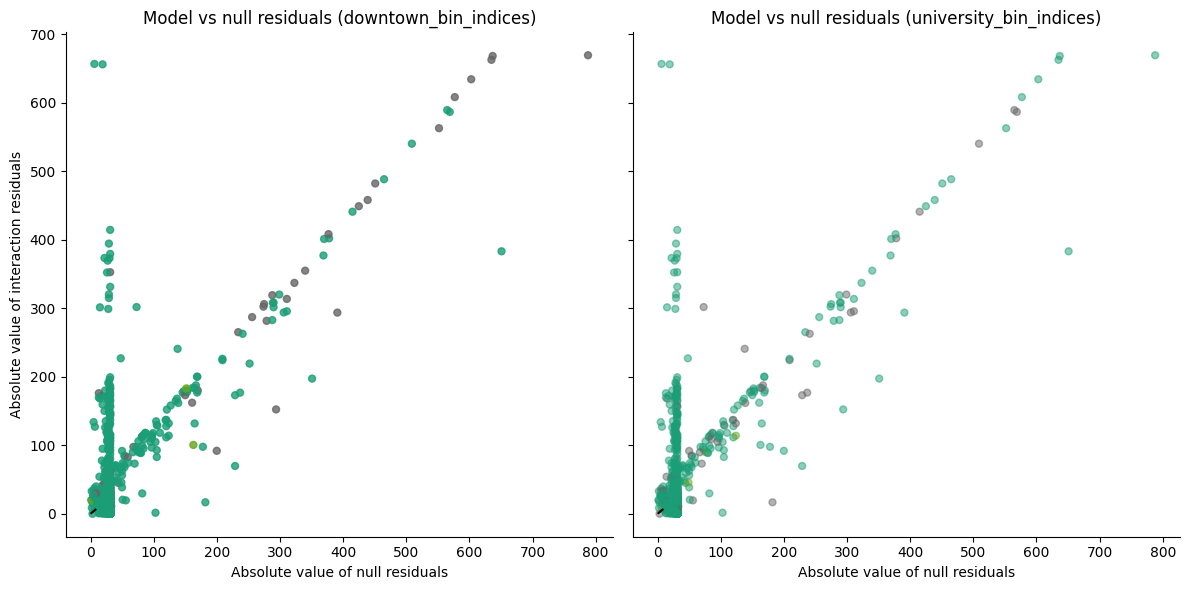

In [18]:

pop_residuals = units_observed_original - pop_preds_units_mean
null_residuals = units_observed_original  - np.mean(units_observed_original)
bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 
# 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

university_overlap = subset['continuous']['university_overlap'].detach().numpy()
downtown_overlap = subset['continuous']['downtown_overlap'].detach().numpy()
university_bin_indices = np.digitize(university_overlap, bins=bins) - 1 
downtown_bin_indices = np.digitize(downtown_overlap, bins=bins) - 1


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].scatter(x=abs(null_residuals), y=abs(pop_residuals),
                 s=25, alpha=0.8, c=downtown_bin_indices, cmap = 'Dark2')
axes[0].set_xlabel("Absolute value of null residuals")
axes[0].set_ylabel("Absolute value of interaction residuals")
axes[0].plot([0, 9], [0, 7], 'k--')
axes[0].set_title("Model vs null residuals (downtown_bin_indices)")

axes[1].scatter(x=abs(null_residuals), y=abs(pop_residuals), 
                s=25, alpha=0.5, c=university_bin_indices, cmap = "Dark2")
axes[1].set_xlabel("Absolute value of null residuals")
axes[1].plot([0, 9], [0, 7], 'k--')
axes[1].set_title("Model vs null residuals (university_bin_indices)")

plt.tight_layout()
sns.despine()
plt.show()

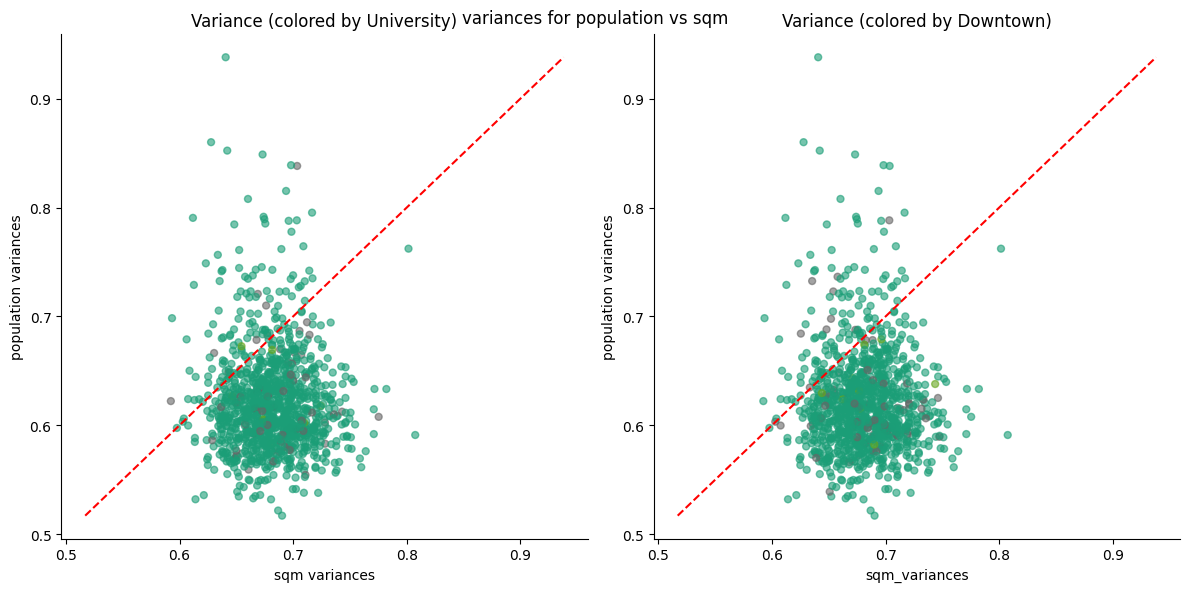

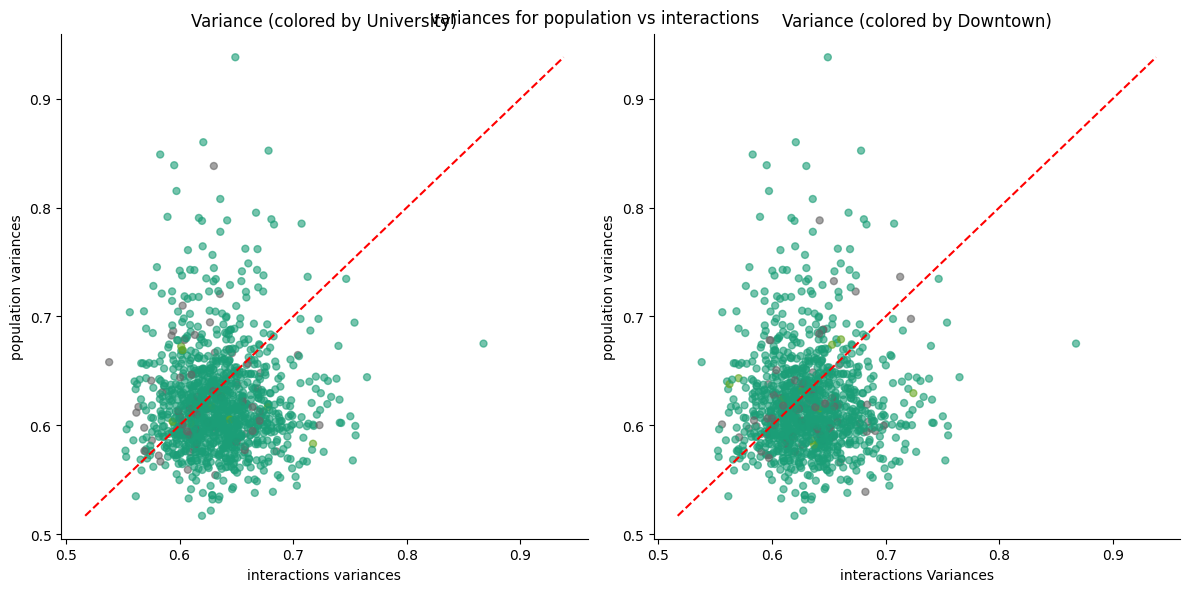

In [23]:

# by University - a bit more variance, but much better than before
pop_variances = population_preds['housing_units'].var(dim=0)
sqm_variances = sqm_preds['housing_units'].var(dim=0)
interaction_variances = interactions_preds['housing_units'].var(dim=0)  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

scatter1 = axes[0].scatter(y=pop_variances, x=sqm_variances, 
                           c=university_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), sqm_variances.min())
max_val = max(pop_variances.max(), sqm_variances.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[0].set_ylabel("population variances")
axes[0].set_xlabel("sqm variances")
axes[0].set_title("Variance (colored by University)")

#by Downtown
scatter2 = axes[1].scatter(y=pop_variances, x=sqm_variances, 
                           c=downtown_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), sqm_variances.min())
max_val = max(pop_variances.max(), sqm_variances.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[1].set_ylabel("population variances")
axes[1].set_xlabel("sqm_variances")
axes[1].set_title("Variance (colored by Downtown)")
sns.despine()
plt.tight_layout()

plt.suptitle("variances for population vs sqm")
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

scatter1 = axes[0].scatter(y=pop_variances, x=interaction_variances, 
                           c=university_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), interaction_variances.min())
max_val = max(pop_variances.max(), interaction_variances.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[0].set_ylabel("population variances")
axes[0].set_xlabel("interactions variances")
axes[0].set_title("Variance (colored by University)")

#by Downtown
scatter2 = axes[1].scatter(y=pop_variances, x=interaction_variances, 
                           c=downtown_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), interaction_variances.min())
max_val = max(pop_variances.max(), interaction_variances.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[1].set_ylabel("population variances")
axes[1].set_xlabel("interactions Variances")
axes[1].set_title("Variance (colored by Downtown)")
sns.despine()
plt.tight_layout()

plt.suptitle("variances for population vs interactions")
plt.show()



In [32]:
# count extreme prediction failures, cases where obs are beyond 99% intervals
units_observed = subset['continuous']['housing_units'].detach().numpy()

quantiles = population_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)

pop_outliers_below = (torch.tensor(units_observed) < quantiles[0,:]).sum()
pop_outliers_above = (torch.tensor(units_observed) > quantiles[1,:]).sum()

print(pop_outliers_below, pop_outliers_above, (pop_outliers_below + pop_outliers_above)/units_observed.shape[-1])


sqm_quantiles = sqm_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)
sqm_outliers_above = (torch.tensor(units_observed) > sqm_quantiles[1,:]).sum()
sqm_outliers_below = (torch.tensor(units_observed) < sqm_quantiles[0,:]).sum()

print(sqm_outliers_below, sqm_outliers_above, (sqm_outliers_below + sqm_outliers_above)/units_observed.shape[-1])

interactions_quantiles = interactions_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)
interaction_outliers_above = (torch.tensor(units_observed) > interactions_quantiles[1,:]).sum()
interaction_outliers_below = (torch.tensor(units_observed) < interactions_quantiles[0,:]).sum()

print(interaction_outliers_below, interaction_outliers_above, (interaction_outliers_below + interaction_outliers_above)/units_observed.shape[-1])


tensor(22) tensor(49) tensor(0.0628)
tensor(9) tensor(49) tensor(0.0513)
tensor(18) tensor(53) tensor(0.0628)
